In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

base_path = "~/Git/stable-diffusion/experiment-2-elisabetta"
#base_path = "~/Library/Mobile Documents/com~apple~CloudDocs/experiment 2 -Elisabetta"

settings = {
    "sd": {
        "path": "experiment_1",
        "color": "tab:blue",
        "linestyle": "dashed",
        "marker": "o",
        "label": "SD 1.5",
    },
    "sd_fabric": {
        "path": "experiment_2",
        "color": "tab:blue",
        "linestyle": "solid",
        "marker": "o",
        "label": "FABRIC (SD)",
    },
    "dp": {
        "path": "experiment_5",
        "color": "tab:orange",
        "linestyle": "dashed",
        "marker": "s",
        "label": "Dreamlike Photoreal",
    },
    "dp_fabric": {
        "path": "experiment_6",
        "color": "tab:orange",
        "linestyle": "solid",
        "marker": "s",
        "label": "FABRIC",
    },
    "hps": {
        "path": "experiment_3",
        "color": "tab:green",
        "linestyle": "dashed",
        "marker": "v",
        "label": "HPS LoRA",
    },
    "hps_fabric": {
        "path": "experiment_4",
        "color": "tab:green",
        "linestyle": "solid",
        "marker": "v",
        "label": "FABRIC + HPS LoRA",
    },
    "fabric_first_half": {
        "path": "experiment_7",
        "color": "tab:red",
        "linestyle": "dashed",
        "marker": "D",
        "label": "FABRIC (first half)",
    },
    "fabric_second_half": {
        "path": "experiment_8",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "D",
        "label": "FABRIC (second half)",
    },
    "fabric_no_neg": {
        "path": "experiment_9",
        "color": "tab:purple",
        "linestyle": "solid",
        "marker": "P",
        "label": "FABRIC (no negative feedback)",
    },
    "fabric_no_pos": {
        "path": "experiment_10",
        "color": "tab:purple",
        "linestyle": "dashed",
        "marker": "P",
        "label": "FABRIC (no positive feedback)",
    },
}



In [12]:
dfs = {}
for label, setting in settings.items():
    df = pd.read_csv(os.path.join(base_path, setting["path"], "metrics.csv"))
    dfs[label] = df
    if "pref_score" in df and df["pref_score"].max() > 100:
        df["pref_score"] = df["pref_score"] / 100

In [13]:
list(dfs.values())[0].keys()

Index(['round', 'prompt_idx', 'image_idx', 'target_img_sim', 'prompt',
       'neg_prompt', 'image', 'round_diversity', 'pos_sim', 'neg_sim', 'seed',
       'liked', 'disliked'],
      dtype='object')

In [14]:
cols = []
for key in ["dp", "dp_fabric", "fabric_first_half", "fabric_second_half", "fabric_no_neg", "fabric_no_pos"]:
    cols.append(dfs[key].loc[dfs[key]["round"] == 0]["target_img_sim"])

max_diffs = []
for i in range(len(cols[0])):
    diffs = []
    for x in range(len(cols)):
        for y in range(x + 1, len(cols)):
            diffs.append(np.abs(cols[x].iloc[i] - cols[y].iloc[i]))
    max_diffs.append(np.max(diffs))
print(np.max(max_diffs))

0.10000000000000853


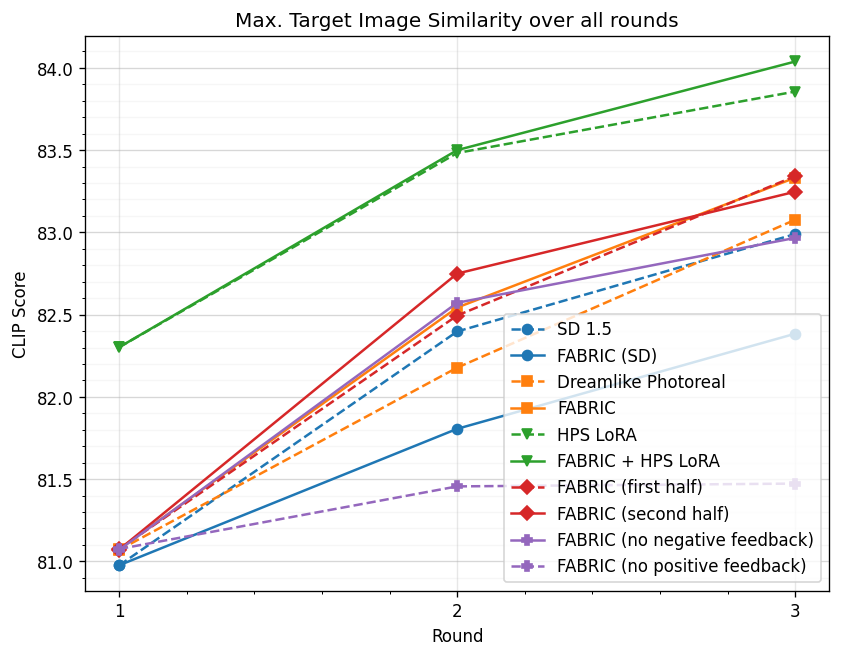

In [15]:
y_key = "target_img_sim"
y_label = "CLIP Score"
y_title = "Target Image Similarity"

data = {}
for name, df in dfs.items():
    rounds = sorted(df["round"].unique())
    ys = [df.loc[df["round"] <= i].groupby(["prompt_idx"])[y_key].max().mean() for i in rounds]
    data[name] = ys

key = next(iter(data.keys()))
assert all(len(v) == len(data[key]) for v in data.values())
xs = np.arange(len(data[key])) + 1

plt.figure(dpi=120, figsize=(8, 6))

for name, ys in data.items():
    plt.plot(xs, ys, label=settings[name]["label"], color=settings[name]["color"], linestyle=settings[name]["linestyle"], marker=settings[name]["marker"])

plt.xticks(xs)
plt.yticks()
plt.xlabel("Round")
plt.ylabel(y_label)
plt.legend(loc="lower right")
plt.minorticks_on()
plt.grid(axis="y", linestyle="-", alpha=0.5, which="major")
plt.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
plt.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.title(f"Max. {y_title} over all rounds")
plt.savefig(f"max_{y_key}_so_far.pdf", bbox_inches="tight")

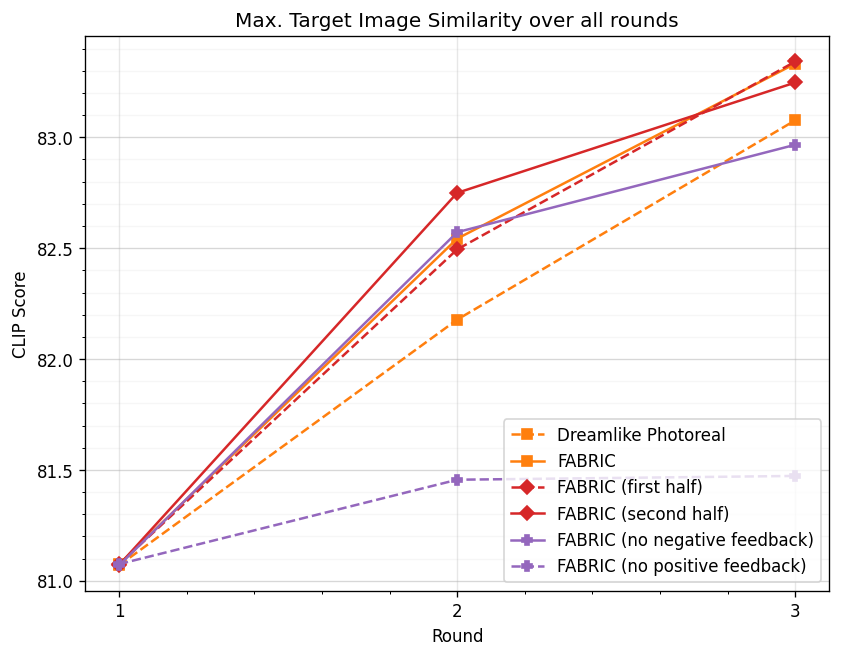

In [16]:


y_key = "target_img_sim"
y_label = "CLIP Score"
y_title = "Target Image Similarity"

data = {}
for name in ["dp", "dp_fabric", "fabric_first_half", "fabric_second_half", "fabric_no_neg", "fabric_no_pos"]:
    df = dfs[name]
    num_rounds = len(df["round"].unique())
    ys = [df.loc[df["round"] <= i].groupby(["prompt_idx"])[y_key].max().mean() for i in range(num_rounds)]
    data[name] = ys

key = next(iter(data.keys()))
assert all(len(v) == len(data[key]) for v in data.values())
xs = np.arange(len(data[key])) + 1

plt.figure(dpi=120, figsize=(8, 6))

for name, ys in data.items():
    plt.plot(xs, ys, label=settings[name]["label"], color=settings[name]["color"], linestyle=settings[name]["linestyle"], marker=settings[name]["marker"])

plt.xticks(xs)
plt.yticks()
plt.xlabel("Round")
plt.ylabel(y_label)
plt.legend(loc="lower right")
plt.minorticks_on()
plt.grid(axis="y", linestyle="-", alpha=0.5, which="major")
plt.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
plt.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.title(f"Max. {y_title} over all rounds")
plt.savefig(f"max_{y_key}_so_far.pdf", bbox_inches="tight")

In [17]:
key1, key2 = "dp", "fabric_no_neg"
df1 = dfs[key1].loc[dfs[key1]["round"] == 0]
df2 = dfs[key2].loc[dfs[key2]["round"] == 0]
(df1.groupby("prompt_idx")["target_img_sim"].max() - df2.groupby("prompt_idx")["target_img_sim"].max()).abs().mean()
# df1["target_img_sim"].mean(), df2["target_img_sim"].mean()
df1.groupby("prompt_idx")["target_img_sim"].max().mean(), df2.groupby("prompt_idx")["target_img_sim"].max().mean()

(81.0691379310345, 81.06896551724138)

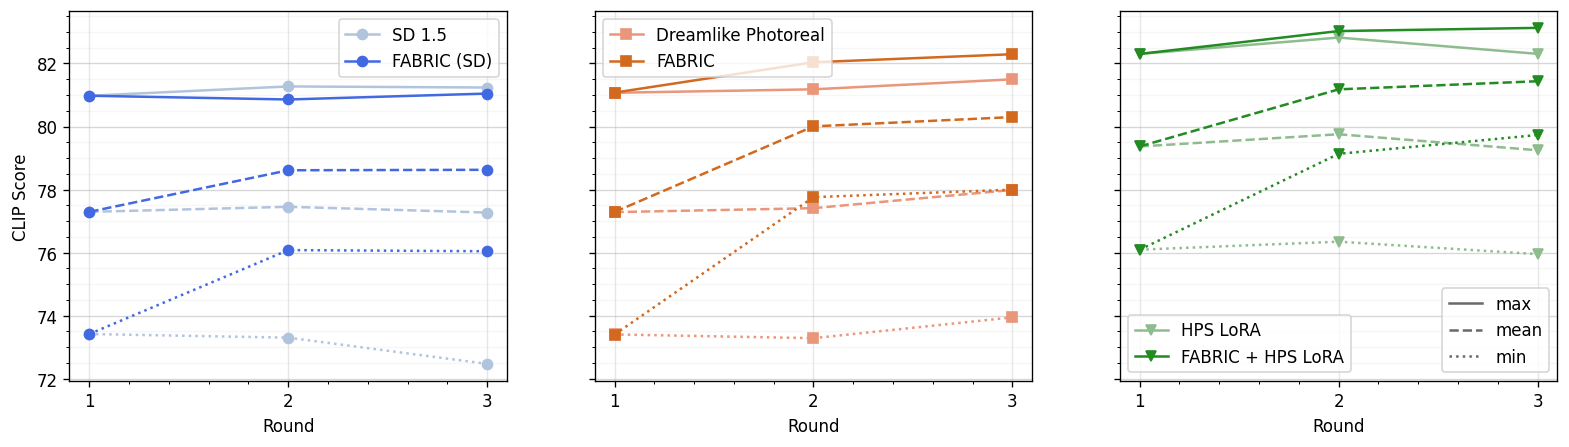

In [24]:
runs = {
    "sd": {
        "color": "lightsteelblue",
        "zorder": 4,
    },
    "sd_fabric": {
        "color": "royalblue",
        "zorder": 6,
    },
    "dp": {
        "color": "darksalmon",
        "zorder": 3,
    },
    "dp_fabric": {
        "color": "chocolate",
        "zorder": 4,
    },
    "hps": {
        "color": "darkseagreen",
        "zorder": 2,
    },
    "hps_fabric": {
        "color": "forestgreen",
        "zorder": 3,
    },
}

y_key = "target_img_sim"
y_label = "CLIP Score"
y_title = "Target Image Similarity"

min_data = {}
mean_data = {}
max_data = {}
for label, df in dfs.items():
    group = df.groupby(["prompt_idx", "round"])[y_key]
    min_data[label] = group.min().groupby("round").mean()
    mean_data[label] = group.mean().groupby("round").mean()
    max_data[label] = group.max().groupby("round").mean()

key = next(iter(min_data.keys()))
assert all(len(v) == len(min_data[key]) for v in min_data.values())
xs = np.arange(len(min_data[key])) + 1


fig, axs = plt.subplots(1, 3, sharey=True, dpi=120, figsize=(16, 4))

legend_elements = []

for i, name in enumerate(runs):
    #plt.subplot(1, 3, i//2 + 1)
    ax = axs[i//2]
    color = runs[name]["color"]
    zorder = runs[name]["zorder"]
    marker = settings[name]["marker"]
    ax.plot(xs, min_data[name], linestyle="dotted", marker=marker, **runs[name])
    ax.plot(xs, mean_data[name], linestyle="dashed", marker=marker, **runs[name])
    ax.plot(xs, max_data[name], linestyle="solid", marker=marker, **runs[name])
    ax.plot([], [], label=settings[name]["label"], color=color, linestyle="solid", marker=marker)

    legend_elements.append(Line2D([], [], color=color, linestyle="solid", label=settings[name]["label"], marker=marker))

group_legend_elements = [
    # Line2D([], [], linestyle="", label=''),
    Line2D([], [], color='dimgray', linestyle="solid", label='max'),
    Line2D([], [], color='dimgray', linestyle="dashed", label='mean'),
    Line2D([], [], color='dimgray', linestyle="dotted", label='min'),
]


# fig.tight_layout()
axs[0].set_ylabel(y_label)
plt.subplot(1, 3, 3)
#plt.title(f"Min/mean/max {y_title} per round")
group_legend = plt.legend(handles=group_legend_elements, loc="lower right")
# plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(-0.01, -0.05), ncol=3, frameon=False)
plt.gca().add_artist(group_legend)
for ax in axs:
    ax.set_xticks(xs)
    ax.set_xlabel("Round")
    ax.legend()
    ax.minorticks_on()
    ax.grid(axis="y", linestyle="-", alpha=0.5, which="major")
    ax.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
    ax.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.savefig(f"{y_key}_per_round.pdf", bbox_inches="tight")

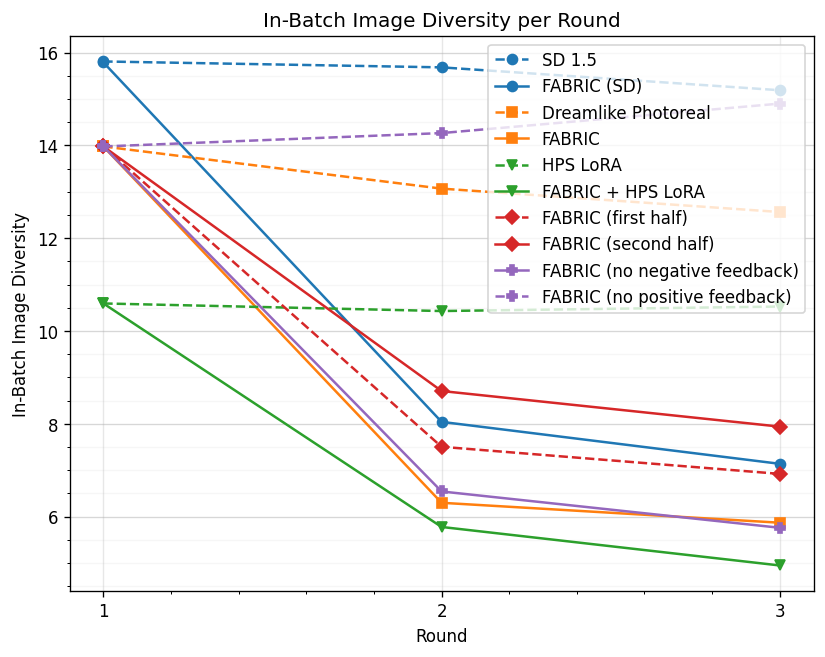

In [88]:
y_key = "round_diversity"
y_label = "In-Batch Image Diversity"
data = {}
for name, df in dfs.items():
    data[name] = 100 - df.groupby(["prompt_idx", "round"])[y_key].mean().groupby("round").mean()

key = next(iter(data.keys()))
assert all(len(v) == len(data[key]) for v in data.values())
xs = np.arange(len(data[key])) + 1

plt.figure(dpi=120, figsize=(8, 6))

for name, ys in data.items():
    plt.plot(xs, ys, label=settings[name]["label"], color=settings[name]["color"], linestyle=settings[name]["linestyle"], marker=settings[name]["marker"])

plt.xticks(xs)
plt.yticks()
plt.xlabel("Round")
plt.ylabel(y_label)
plt.legend(loc="upper right")
plt.minorticks_on()
plt.grid(axis="y", linestyle="-", alpha=0.5, which="major")
plt.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
plt.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.title(f"{y_label} per Round")
plt.savefig(f"{y_key}_per_round.pdf", bbox_inches="tight")

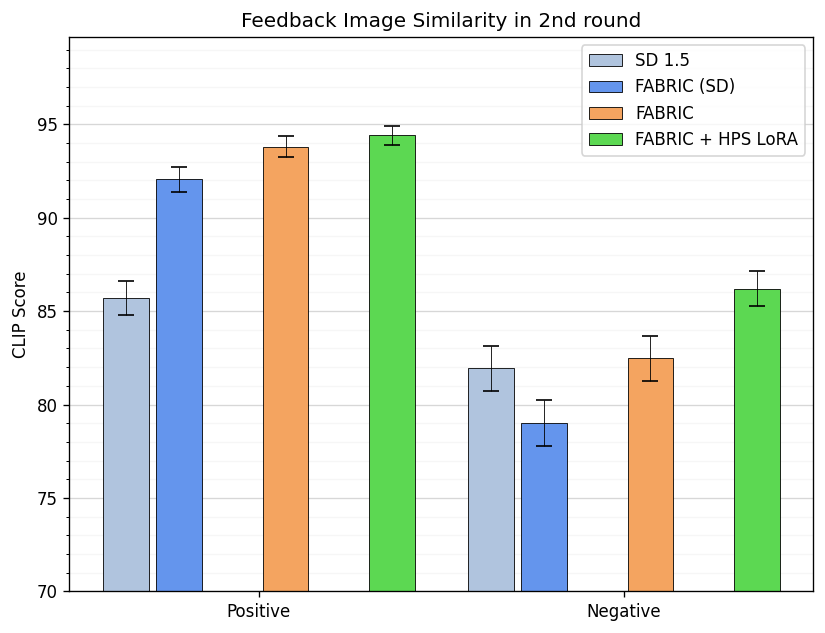

In [108]:
runs = {
    "sd": {
        "color": "lightsteelblue",
    },
    "sd_fabric": {
        "color": "cornflowerblue",
    },
    "dp": {
        "color": "peachpuff",
    },
    "dp_fabric": {
        "color": "sandybrown",
    },
    "hps": {
        "color": "#B6F0B1",
    },
    "hps_fabric": {
        "color": "#5CD852",
    },
}

y_pos_key = "pos_sim"
y_neg_key = "neg_sim"
y_title = "Feedback Image Similarity"
y_label = "CLIP Score"

data = {}
confidence = {}
for name in runs.keys():
    df = dfs[name]
    group = df.loc[df["round"] == 1]
    pos_sim = group[y_pos_key].mean()
    neg_sim = group[y_neg_key].mean()
    pos_std = group[y_pos_key].std()
    neg_std = group[y_neg_key].std()
    data[name] = (pos_sim, neg_sim)
    # 95% confidence interval
    pos_confidence = 1.96 * pos_std / np.sqrt(len(group))
    neg_confidence = 1.96 * neg_std / np.sqrt(len(group))
    confidence[name] = (pos_confidence, neg_confidence)

xs = np.array([0, 1.2])

fig, ax = plt.subplots(dpi=120, figsize=(8, 6))
plt.grid(axis="y", linestyle="-", alpha=0.5, which="major", zorder=0)
plt.grid(axis="y", linestyle="-", alpha=0.1, which="minor", zorder=0)

padding = 0.025
width = (1 - padding)/len(runs) - padding/2


for i, name in enumerate(runs.keys()):
    x = xs + i*(width + padding) + width/2 - 0.5 - padding/2
    color = runs[name]["color"]
    if not np.isnan(data[name][0]) and not np.isnan(confidence[name][0]):
        plt.bar(x, data[name], width=width, color=color, edgecolor="black", linewidth=0.5, zorder=2, label=settings[name]["label"])
        plt.errorbar(x, data[name], yerr=confidence[name], fmt='none', ecolor='black', linewidth=0.5, capsize=5, zorder=3)

plt.xticks(xs)
plt.xticks(xs, ["Positive", "Negative"])
plt.yticks()
plt.ylim(70, None)
plt.ylabel(y_label)
plt.legend(loc="upper right")
plt.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.title(f"{y_title} in 2nd round")
plt.savefig(f"feedback_sim_per_round.pdf", bbox_inches="tight")